# `cmip6 preprocessing Workflow` 

## What is CMIP6?

The Climate Model Intercomparison Project - Phase 6 [CMIP6](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6) is a globally coordinated effort to run many climate models under identical protocols (e.g. certain emission scenarios). The output of all of these models are however very large. The size of all this output renders the 'download-and-analyze' model, which many of us use pretty inefficient. The solution to this problem is to use data stored in the cloud.
But even with the data accessible almost instantly, analysis is still not as easy as one would want. 

Entering `cmip6_preprocessing` a python package that aims to make CMIP data fully analysis ready by fixing issues in a centralized, community driven code base (as opposed to tons of `if/else` statements in your notebook).

In this tutorial you will learn how to work with CMIP6 data in the cloud.
This includes:
- Finding and selecting data
- Loading the data
- Combining different datasets
- Masking out ocean basins
- Removing model drift
    
All of these assume a basic knowledge of python and xarray.

## Where do I find the data?

The official CMIP6 archive is maintained by [ESGF](https://esgf-node.llnl.gov/projects/cmip6/), but downloadind data from there can be a time and storage consuming task. The pangeo Project has mirrored a substantial part of the archive to the [cloud](https://pangeo-data.github.io/pangeo-cmip6-cloud/) (not all of them though, so if you are missing something always check on the ESGF site first).

So now that you know where the data is located (we are going to use the data on Google Cloud, since this is where our computations will happen). 

All the CMIP6 variables follow a stric vocabulary, so you might want to check out this handy [spreadsheet by Naomi Henderson](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271). For the example below, I was curious about the surface nitrate concentrations `no3os`
![image.png](attachment:74018d8b-b501-459a-a813-412959dec680.png)
and the sea surface temperature `tos`.

## Finding and Selecting data 

Importing modules which will be helpful in visualizing the climate dataset and selecting with specific filters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import intake
from dask.diagnostics import ProgressBar

Here [intake](https://intake-esm.readthedocs.io/en/latest/api.html) module is used for selecting data and filtering it in an efficient way. In the next cell we are going  to use [google_cmip_col](https://cmip6-preprocessing.readthedocs.io/en/latest/api.html#module-cmip6_preprocessing.utils) which is using an intake plugin for parsing an ESM (Earth System Model) Collection/catalog and loading assets (netCDF files and/or Zarr stores) into xarray datasets. Which in turn create the in-memory representation for the catalog is a Pandas DataFrame. That's why we are able to see the content of dataset using col.df . Now why we should know about where this intake is been used is because in the next few cells we are going to use some methods on this col dataset like col.search( ) to filter the data according to some specific filters like model name here source_id. So these methods can be found in intake-esm page under API section.

In [2]:
from cmip6_preprocessing.utils import google_cmip_col

# Initialize the Pangeo CMIP6 cloud collection
col = google_cmip_col() 
col

,unique
activity_id,18
institution_id,37
source_id,87
experiment_id,170
member_id,651
table_id,38
variable_id,710
grid_label,11
zstore,511425
dcpp_init_year,60


**The collection is based on a pandas dataframe:**

In [3]:
col.df
# we can access the attributes of the models using pandas objects

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hfls,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,zg,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
511420,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,sfcWind,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511421,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,uas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511422,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,day,rlut,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511423,ScenarioMIP,AS-RCEC,TaiESM1,ssp585,r1i1p1f1,day,tasmin,gn,gs://cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/s...,NaN,20210721


You can find the dataset we want to analyze and [manually load it with xarray](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html#opening-a-single-zarr-data-store), but that is cumbersome.

Instead we are using the abilities of the `col` object, powered by [intake-esm](https://intake-esm.readthedocs.io/en/latest/) to narrow down our search critera and load the data.

The [intake-esm](https://intake-esm.readthedocs.io/en/latest/user-guide/index.html) user guide introduces the main concepts required for accessing Earth Sytem Model (ESM) data catalogs and loading data assets into xarray containers. And it's API will help us to envestigate about the attributes of the model-

In [4]:
model = col.search(source_id='FGOALS-g3')
model

,unique
activity_id,5
institution_id,1
source_id,1
experiment_id,18
member_id,6
table_id,8
variable_id,112
grid_label,1
zstore,2364
dcpp_init_year,0


In [5]:
# If we want to 
model.df['variable_id'].tolist()

['rsds',
 'rsdscs',
 'rsus',
 'zg',
 'tauv',
 'va',
 'ua',
 'ts',
 'tauu',
 'tasmin',
 'wap',
 'clwvi',
 'tasmax',
 'rsus',
 'tasmin',
 'rsutcs',
 'rsut',
 'rlutcs',
 'rsds',
 'rsdscs',
 'tas',
 'tasmax',
 'tasmin',
 'rsdt',
 'evspsbl',
 'clw',
 'clt',
 'ta',
 'rtmt',
 'sfcWind',
 'ta',
 'tas',
 'hur',
 'hfss',
 'hfls',
 'evspsbl',
 'clwvi',
 'clw',
 'clt',
 'clivi',
 'cl',
 'tas',
 'rlut',
 'o3',
 'pfull',
 'clivi',
 'cli',
 'cl',
 'rsuscs',
 'rsut',
 'rsutcs',
 'rtmt',
 'sfcWind',
 'tas',
 'rsutcs',
 'clwvi',
 'mc',
 'pr',
 'phalf',
 'rlus',
 'rlut',
 'rsutcs',
 'clivi',
 'pfull',
 'rldscs',
 'prsn',
 'phalf',
 'rtmt',
 'o3',
 'mc',
 'rtmt',
 'wap',
 'va',
 'ua',
 'ts',
 'ta',
 'tauv',
 'tauu',
 'tas',
 'tasmax',
 'tasmin',
 'zg',
 'prc',
 'rsuscs',
 'prsn',
 'ps',
 'huss',
 'hus',
 'hur',
 'hfss',
 'hfls',
 'rlutcs',
 'rlut',
 'rsdt',
 'rlus',
 'clw',
 'cli',
 'cl',
 'rldscs',
 'rsut',
 'rsuscs',
 'rsus',
 'rsdt',
 'rsdscs',
 'rsds',
 'hfls',
 'rlutcs',
 'rlus',
 'rldscs',
 'rlds',


We are extracting the total number of distinct models that the CMIP6 cloud contain

In [6]:
np.sort(col.df['source_id'].unique()) 

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR',
       'BCC-CSM2-HR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0',
       'CAS-ESM2-0', 'CESM1-1-CAM5-CMIP5', 'CESM1-WACCM-SC', 'CESM2',
       'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM',
       'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-CM2-VHR4', 'CMCC-ESM2',
       'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA',
       'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-LR',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'EC-Earth3P', 'EC-Earth3P-HR',
       'EC-Earth3P-VHR', 'ECMWF-IFS-HR', 'ECMWF-IFS-LR', 'FGOALS-f3-H',
       'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-AM4', 'GFDL-CM4',
       'GFDL-CM4C192', 'GFDL-ESM2M', 'GFDL-ESM4', 'GFDL-OM4p5B',
       'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'GISS-E2-2-G',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-LM',
       'HadGEM3-GC31-MM', 'IITM-ESM', 'I

Total number of models-

In [7]:
(np.sort(col.df['source_id'].unique()) ).size

87

### We are passing specific model specification to filter out the data

In [8]:
# create a subcollection with certain search criteria

# We have passed the models into a list which we want to extract from CMIP6 catalog 
models = ['CanESM5-CanOE', 'IPSL-CM6A-LR', 'EC-Earth3', 'ECMWF-IFS-LR']


cat = col.search(
    variable_id=['tos', 'no3os'],
    source_id=models,
    experiment_id=['historical', 'ssp585'],
    grid_label='gn',
    table_id='Omon',
    member_id = ['r2i1p1f1', 'r3i1p1f1', 'r2i1p2f1', 'r3i1p2f1'] 
)

# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


***The result is a python dictionary with many xarray Datasets***

In [9]:
ddict

{'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.r2i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r2i1p1f1/Omon/tos/gn/v20191121/.nan.20191121': <xarray.Dataset>
 Dimensions:         (y: 332, x: 362, nvertex: 4, time: 1032, axis_nbounds: 2)
 Coordinates:
     bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
     bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
     nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
     nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
   * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
     time_bounds     (time, axis_nbounds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
 Dimensions without coordinates: y, x, nvertex, axis_nbounds
 Data variables:
     area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
     tos            

***Why would I need cmip6_preprocessing? Well take a closer look at for instance the dimensions:***

In [10]:
ds_a = ddict['ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.r3i1p1f1.Omon.no3os.gn.gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r3i1p1f1/Omon/no3os/gn/v20191121/.nan.20191121']

In [11]:
ds_a

<xarray.Dataset>
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 1032, axis_nbounds: 2)
Coordinates:
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bounds     (time, axis_nbounds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    no3os           (time, y, x) float32 dask.array<chunksize=(229, 332, 362), meta=np.ndarray>
Attributes: (12/56)
    CMIP6_CV_version:        cv=6.2.15.1
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   ssp585
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    ...                      ...
    variant_info:            Each member starts from the corresponding member...
    variant_label:           r3i1p1f1
    netcdf_tracking_ids:     hdl:21.14100/16748c0f-5b2f-433c-80ea-6e1e2ef93391
    version_id:              v20191121
    intake_esm_varname:      None
    intake_esm_dataset_key:  ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.r3i1p1f1.Om...

In [12]:
ds_b = ddict['ScenarioMIP.CCCma.CanESM5-CanOE.ssp585.r3i1p2f1.Omon.no3os.gn.gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5-CanOE/ssp585/r3i1p2f1/Omon/no3os/gn/v20190429/.nan.20190429']
ds_b

<xarray.Dataset>
Dimensions:             (i: 360, j: 291, time: 1032, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    no3os               (time, j, i) float32 dask.array<chunksize=(206, 291, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
Attributes: (12/58)
    CCCma_model_hash:            e1dfe5dd4f8002c810d891dfb4bb84996b9219d6
    CCCma_parent_runid:          c2-his03
    CCCma_pycmor_hash:           206ad17fba3c039e0dbc8fef0abd20e8d13d0f18
    CCCma_runid:                 c2-s8503
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   2015:01:01:00
    ...                          ...
    variant_label:               r3i1p2f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/1b0f783f-d808-4274-bba9-ff383d9...
    version_id:                  v20190429
    intake_esm_varname:          None
    intake_esm_dataset_key:      ScenarioMIP.CCCma.CanESM5-CanOE.ssp585.r3i1p...

In [13]:
print(ds_a.dims)
print(ds_b.dims)

Frozen({'y': 332, 'x': 362, 'nvertex': 4, 'time': 1032, 'axis_nbounds': 2})
Frozen({'i': 360, 'j': 291, 'time': 1032, 'bnds': 2, 'vertices': 4})


Now we can clearly see that these are not the same and so if you want to average several model in space, you would have to write a ton of `if/else` statements...
This is the original reason I wrote cmip6_preprocessing: To take thes tedious bookkeeping tasks out and enable users to work with truly analysis ready data

## Preprocessing the data

We have *combined_preprocessing* for this work where it changes the label of the dimension and create a plateform where we can march one step ahead towards analysis 

In [14]:
from cmip6_preprocessing.preprocessing import combined_preprocessing
print(combined_preprocessing(ds_a).dims)
print(combined_preprocessing(ds_b).dims)

Frozen({'y': 332, 'x': 362, 'time': 1032, 'vertex': 4, 'bnds': 2})
Frozen({'time': 1032, 'y': 291, 'x': 360, 'bnds': 2, 'vertex': 4})


🚀 Now things look great. But for convenience you can also plug this functionality in your 'read-in' procedure:

### Loading the datasets into a python dictionary

In [15]:
# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
    preprocess=combined_preprocessing, # this applies the preprocessing to all datasets
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


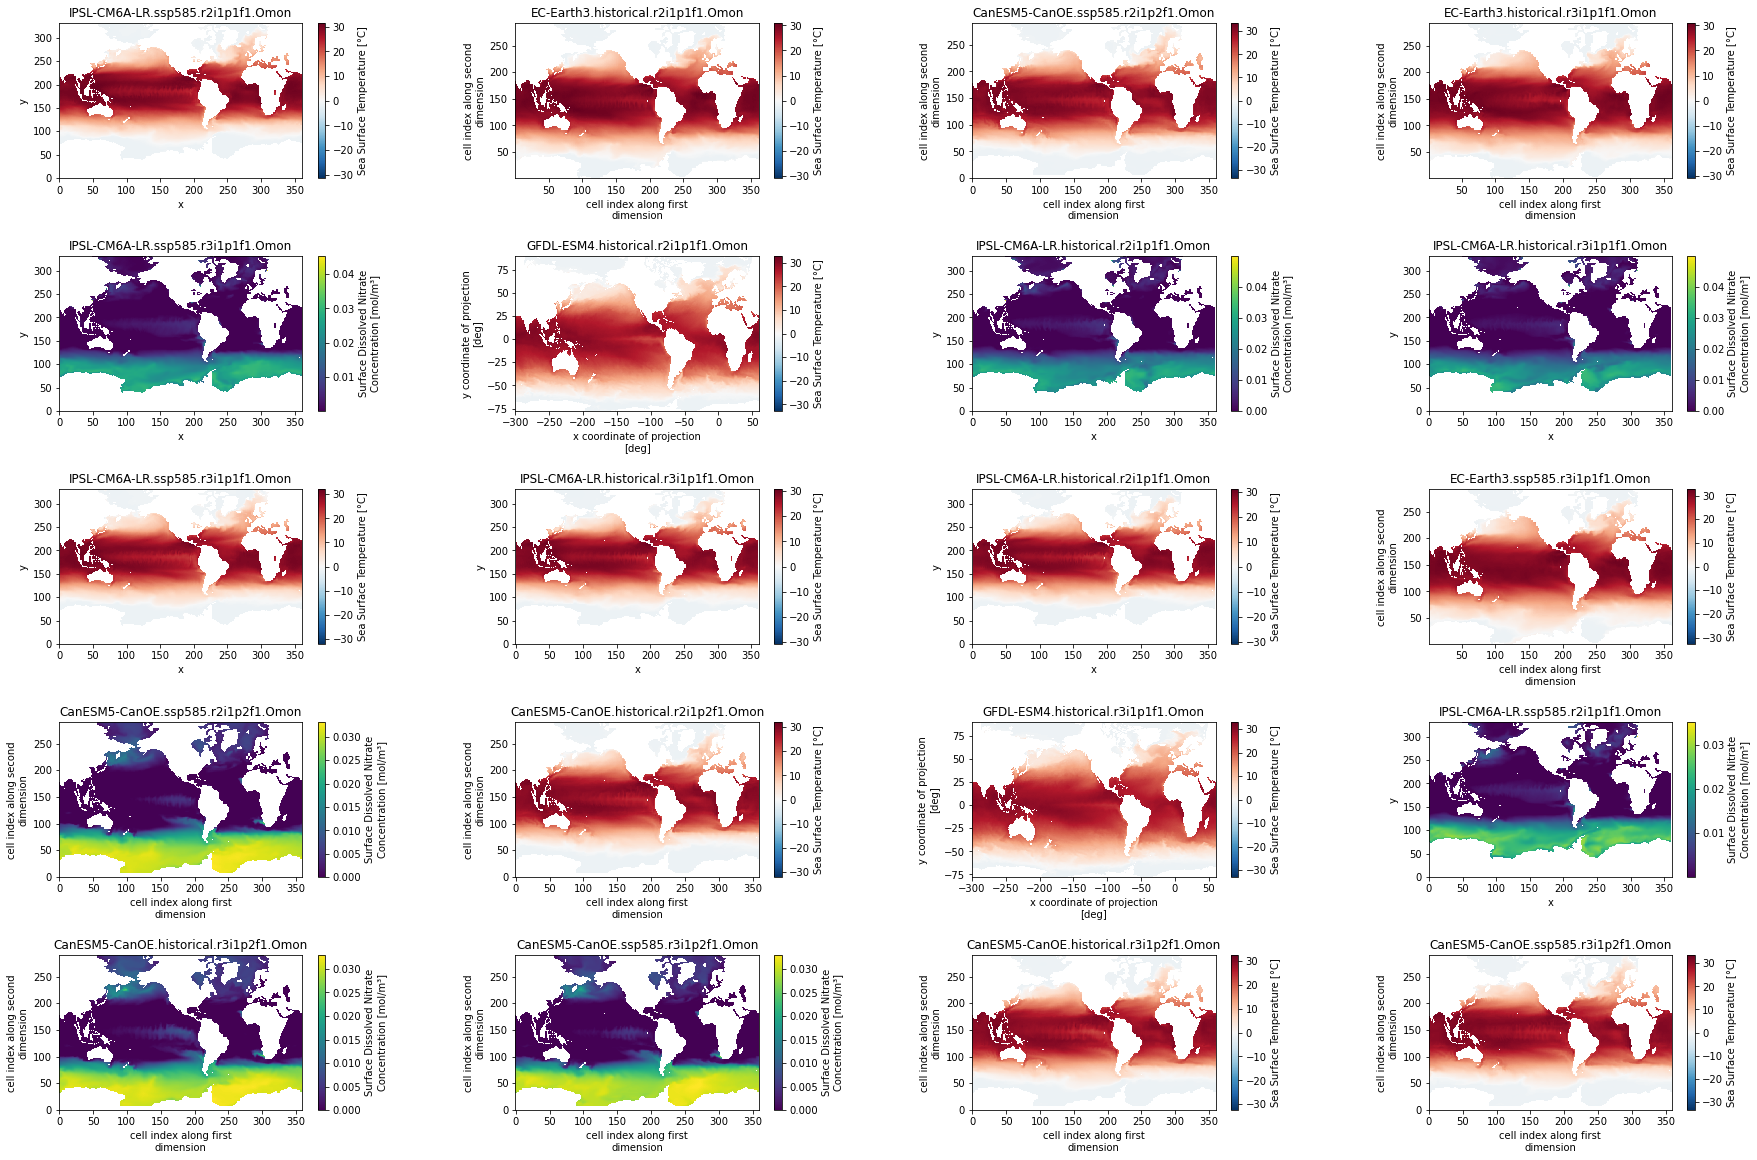

In [17]:
# quick example of how to loop over several models
from cmip6_preprocessing.utils import cmip6_dataset_id
fig, axarr = plt.subplots(ncols=4, nrows=5, figsize=[30,20])
for ax, (name, ds) in zip(axarr.flat, ddict.items()):
    # select the first time step
    ds = ds.isel(time=100)
    # select the datavariable
    da = ds[ds.variable_id]
    # plot
    
    da.plot(ax=ax)
    ax.set_title('.'.join(cmip6_dataset_id(ds).split('.')[2:6]))
    
fig.subplots_adjust(hspace=0.5, wspace=0.5)

Ok fair, but that might not yet very helpful to do actual science, these are just a bunch of single datasets representing single variables, members and models. For many purposes we would rather have variables combined and maybe (depending on your workflow) even concatenating the members?

## Combining dufferent Datasets: The postprocessing module

The cmip6_preprocessing.postprocessing module provides a bunch of functions to make this a lot easier:

In [18]:

from cmip6_preprocessing.postprocessing import merge_variables, concat_members, concat_experiments

# Tip: execute each function separately to see how things change
ddict_combined = concat_members(concat_experiments(merge_variables(ddict)))

KeyError: 'variable_id'

This can happen with some models. In the case of models where both *variable_ids* are available the attribute *variable_id* is deleted. This does not happen for cases where only tos is available. So In that case Manually removing variable_id after merge_variables , and experiment_id after concat_experiments will going to resolve this :

In [ ]:
ddict_combined_a = merge_variables(ddict)
def maybe_remove_attrs(ds, attr):
    if attr in ds.attrs.keys():
        del ds.attrs[attr]
    return ds
# remove the `variable_id` attr manually
ddict_combined_aa = {k:maybe_remove_attrs(ds, 'variable_id') for k,ds in ddict_combined_a.items()}
ddict_combined_b = concat_experiments(ddict_combined_aa)
# same thing for experiment_id
ddict_combined_bb = {k:maybe_remove_attrs(ds, 'experiment_id') for k,ds in ddict_combined_b.items()}
ddict_combined = concat_members(ddict_combined_bb)

In [ ]:
ddict_combined.keys()

In [ ]:
ddict_combined['IPSL-CM6A-LR.gn.Omon']

In [ ]:
ddict_combined['EC-Earth3.gn.Omon']

In [ ]:
ddict_combined['CanESM5-CanOE.gn.Omon']

In [ ]:
ddict_combined['GFDL-ESM4.gn.Omon']

Now we can see thats a lot less datasets, since the members and variables have been combined, and the experiments have been concatenated together. So we end up with one dataset per model


***So now we could do something more advanced in the loop***

In [ ]:

fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=[20,10])
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):
    # show just the first time step
    ds = ds.isel(time=0)
    
    # mask out the SST where the SST is above 25 deg
    da = ds.tos.where(ds.tos>=25)
    
    # average all members
    if 'member_id' in da.dims:
        da = da.mean('member_id')
    da.plot(ax=ax, robust=True)
    ax.set_title(name)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

## Masking ocean basins

Maybe you just want to look at these values in the Arabian Sea? Then in that case We can make a mask which map our data and extract just mapped data for us. 

In [ ]:
import regionmask
from cmip6_preprocessing.regionmask import merged_mask
# load ocean basin data
basins = regionmask.defined_regions.natural_earth.ocean_basins_50


Masking for Arabian sea. We have used [regionmask](https://regionmask.readthedocs.io/en/stable/defined_scientific.html#all) module to mask and you can access digit for corresponding ocean basin 

In [ ]:
fig, axarr = plt.subplots(ncols=2, nrows=2, figsize=[15,10])
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):
    # show just the first time step
    ds = ds.isel(time=0)

    
    # mask out the SSH where the SST is above 20 deg
    da = ds.tos.where(ds.tos>=25)
    
    # average all members
    if 'member_id' in da.dims:
        da = da.mean('member_id')
        
    # mask out the indian ocean
    mask = merged_mask(basins, da)
    
    da_masked = da.where(mask == 53) # switch the number here for a different basin.
    
    da_masked.plot(ax=ax, robust=True)
    ax.set_title(name)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

In [ ]:

time_window = 36 # for monthly data here this is a 3 year window

fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=[14,4], sharey=True)
for ax, (name, ds) in zip(axarr.flat, ddict_combined.items()):    
    # mask out the SSH where the SST is above 20 deg
    da = ds.tos.where(ds.tos>=25)
        
    # mask out the indian ocean
    mask = merged_mask(basins, da)
    
    da_masked = da.where(mask == 5)
    
    da_timeseries = da_masked.mean(['x', 'y'])
    # this is now a heavy computation, using the full dataset!
    with ProgressBar():
        da_timeseries = da_timeseries.load()
    
    da_timeseries = da_timeseries.coarsen(time=time_window, boundary='trim').mean() # average in 3 year intervals to supress short term variability
    
   
    da_timeseries.plot(ax=ax, hue='member_id', color='C0', add_legend=False)
    ax.set_title(name)
fig.subplots_adjust(hspace=0.5, wspace=0.5)